In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from plotly import graph_objects as go
import plotly.express as px
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

src_url = 'https://baseballsavant.mlb.com/leaderboard/custom?year=2021,2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=15&sortDir=desc&min=q&selections=player_age,b_total_pa,b_k_percent,b_bb_percent,xba,xslg,woba,xwoba,xobp,xiso,wobacon,xwobacon,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,hard_hit_percent,pull_percent,straightaway_percent,opposite_percent,batted_ball,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,hp_to_1b,&chart=false&x=xba&y=xba&r=no&chartType=beeswarm'

#### pybaseball docs  
https://github.com/jldbc/pybaseball/tree/master/docs

pitching_stats(start_season, end_season=None, league='all', qual=1, ind=1)  
statcast_pitcher(start_dt=[yesterday's date], end_dt=None, player_id)

In [2]:
from pybaseball import pitching_stats, batting_stats, statcast_batter, statcast_pitcher, playerid_lookup

In [4]:
data = pitching_stats(2021, qual=1)

In [5]:
playerid_lookup('pressly', 'ryan')#['key_mlbam'][1]

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,pressly,ryan,519151,presr001,pressry01,7005,2013.0,2021.0


Gathering Player Data


<AxesSubplot:xlabel='game_date'>

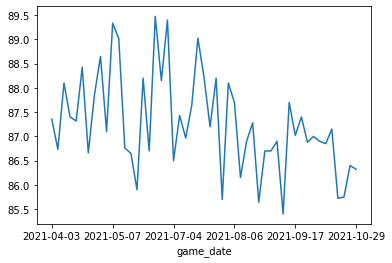

In [75]:
#playerid_lookup('burnes', 'corbin')['key_mlbam'][0]
sc = statcast_pitcher('2021-03-20', '2021-11-05', playerid_lookup('graveman', 'kendall')['key_mlbam'][0])
sc[sc['pitch_type']=='SL'].groupby('game_date')['release_speed'].mean().plot()

In [3]:
sc = statcast_batter('2021-03-20', '2021-11-04', playerid_lookup('altuve', 'jose')['key_mlbam'][0])

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [4]:
sc.if_fielding_alignment.value_counts()/sc.shape[0]

Standard         0.739288
Infield shift    0.202614
Strategic        0.057734
Name: if_fielding_alignment, dtype: float64

In [5]:
sc.groupby('pitch_type')[['release_speed', 'release_spin_rate']].mean()

,release_speed,release_spin_rate
pitch_type,,
CH,84.470261,1693.379085
CS,73.450000,2250.000000
CU,79.380645,2459.672811
FA,68.133333,1807.000000
FC,88.880838,2337.317365
FF,93.987707,2260.029621
FS,87.300000,1438.148148
KC,80.534545,2540.000000
KN,78.620000,332.400000


In [6]:
sc.groupby('zone')['game_year'].count()

zone
1      95
2     147
3     140
4     121
5     173
6     167
7      97
8     148
9     175
11    312
12    381
13    216
14    582
Name: game_year, dtype: int64

In [57]:
sc['month'] = sc.game_date.apply(lambda x: pd.to_datetime(x).month)

In [61]:
sc.game_type.value_counts()

R    2489
L     108
D      88
W      69
Name: game_type, dtype: int64

In [8]:
sc.hit_distance_sc.sort_values(ascending=False)

2033    435.0
0       434.0
2634    426.0
386     422.0
186     416.0
        ...  
2747      NaN
2748      NaN
2749      NaN
2751      NaN
2752      NaN
Name: hit_distance_sc, Length: 2754, dtype: float64

<AxesSubplot:xlabel='hc_x', ylabel='hc_y'>

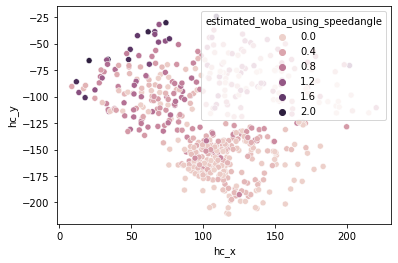

In [12]:
import seaborn as sns
sns.scatterplot(x=sc.hc_x, y=-sc.hc_y, hue=sc.estimated_woba_using_speedangle)

In [22]:
sc.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [69]:
sc_events = sc[(sc['events'].isin(['home_run', 'single', 'double', 'triple'])) & (sc['game_type']!='R')]
px.scatter(sc_events,
    x=sc_events.plate_x,#hc_x
    y=sc_events.plate_z,#hc_z
    color=sc_events.events,
    hover_name=sc_events.game_date,
    hover_data=['zone', 'pitch_type', 'bb_type', 'hit_distance_sc', 'release_speed', 'launch_speed', 'launch_angle', 'estimated_woba_using_speedangle', 'sz_top', 'sz_bot'],
    size='woba_value'
)


In [13]:
sc.groupby('game_pk').agg({'woba_value':'sum', 'woba_denom':'sum'}).sum()

woba_value    271.35
woba_denom    742.00
dtype: float64

In [16]:
271.35/742

0.36570080862533694

In [15]:
sc.estimated_woba_using_speedangle.mean()

0.3412196428571429

In [17]:
sc.query('if_fielding_alignment!="Standard"')[['woba_value', 'woba_denom']].sum()

woba_value     69.15
woba_denom    190.00
dtype: float64

In [19]:
69.15/190

0.3639473684210527

In [51]:
sc.events.value_counts().index.tolist()

['field_out',
 'single',
 'strikeout',
 'walk',
 'home_run',
 'double',
 'force_out',
 'grounded_into_double_play',
 'sac_fly',
 'field_error',
 'hit_by_pitch',
 'double_play',
 'fielders_choice_out',
 'sac_bunt',
 'fielders_choice',
 'triple']

In [52]:
fig = go.Figure(go.Scatter(
    x=sc.query('if_fielding_alignment!="Standard"')['plate_x'],
    y=sc.query('if_fielding_alignment!="Standard"')['plate_z'],
    mode='markers',
    colorscale=[[0, 'red'], [1, 'green']],
    #marker=dict(color = [sc[k] for k in sc['events'].values])
))
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'colorscale'

Did you mean "hoverlabel"?

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            textposition .
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            texttemplate .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for  x
            .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for  y
            .
        
Did you mean "hoverlabel"?

Bad property path:
colorscale
^^^^^^^^^^

In [39]:
{i:k for i in sc.columns for k in range(len(sc.columns))}

{'pitch_type': 91,
 'game_date': 91,
 'release_speed': 91,
 'release_pos_x': 91,
 'release_pos_z': 91,
 'player_name': 91,
 'batter': 91,
 'pitcher': 91,
 'events': 91,
 'description': 91,
 'spin_dir': 91,
 'spin_rate_deprecated': 91,
 'break_angle_deprecated': 91,
 'break_length_deprecated': 91,
 'zone': 91,
 'des': 91,
 'game_type': 91,
 'stand': 91,
 'p_throws': 91,
 'home_team': 91,
 'away_team': 91,
 'type': 91,
 'hit_location': 91,
 'bb_type': 91,
 'balls': 91,
 'strikes': 91,
 'game_year': 91,
 'pfx_x': 91,
 'pfx_z': 91,
 'plate_x': 91,
 'plate_z': 91,
 'on_3b': 91,
 'on_2b': 91,
 'on_1b': 91,
 'outs_when_up': 91,
 'inning': 91,
 'inning_topbot': 91,
 'hc_x': 91,
 'hc_y': 91,
 'tfs_deprecated': 91,
 'tfs_zulu_deprecated': 91,
 'fielder_2': 91,
 'umpire': 91,
 'sv_id': 91,
 'vx0': 91,
 'vy0': 91,
 'vz0': 91,
 'ax': 91,
 'ay': 91,
 'az': 91,
 'sz_top': 91,
 'sz_bot': 91,
 'hit_distance_sc': 91,
 'launch_speed': 91,
 'launch_angle': 91,
 'effective_speed': 91,
 'release_spin_rate':

AttributeError: module 'seaborn' has no attribute 'move_legend'

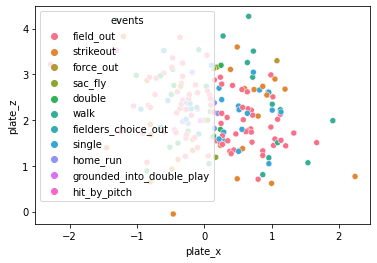

In [31]:
ax = sns.scatterplot(x=sc.query('if_fielding_alignment!="Standard"')['plate_x'],
                y=sc.query('if_fielding_alignment!="Standard"')['plate_z'],
               hue=sc.query('if_fielding_alignment!="Standard"')['events'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
statcast_pithcer()

In [20]:
b = batting_stats(2021, qual=1)

In [21]:
b[['Name', 'WAR']]['WAR'].sum()

572.6999999999999

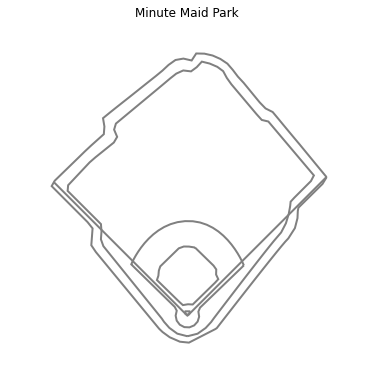

In [20]:
from pybaseball import plot_stadium
plot_stadium('astros')

In [13]:
for i in b:
    print(i)

IDfg
Season
Name
Team
Age
G
AB
PA
H
1B
2B
3B
HR
R
RBI
BB
IBB
SO
HBP
SF
SH
GDP
SB
CS
AVG
GB
FB
LD
IFFB
Pitches
Balls
Strikes
IFH
BU
BUH
BB%
K%
BB/K
OBP
SLG
OPS
ISO
BABIP
GB/FB
LD%
GB%
FB%
IFFB%
HR/FB
IFH%
BUH%
wOBA
wRAA
wRC
Bat
Fld
Rep
Pos
RAR
WAR
Dol
Spd
wRC+
WPA
-WPA
+WPA
RE24
REW
pLI
phLI
PH
WPA/LI
Clutch
FB% (Pitch)
FBv
SL%
SLv
CT%
CTv
CB%
CBv
CH%
CHv
SF%
SFv
KN%
KNv
XX%
PO%
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing%
Z-Swing%
Swing%
O-Contact%
Z-Contact%
Contact%
Zone%
F-Strike%
SwStr%
BsR
FA% (sc)
FT% (sc)
FC% (sc)
FS% (sc)
FO% (sc)
SI% (sc)
SL% (sc)
CU% (sc)
KC% (sc)
EP% (sc)
CH% (sc)
SC% (sc)
KN% (sc)
UN% (sc)
vFA (sc)
vFT (sc)
vFC (sc)
vFS (sc)
vFO (sc)
vSI (sc)
vSL (sc)
vCU (sc)
vKC (sc)
vEP (sc)
vCH (sc)
vSC (sc)
vKN (sc)
FA-X (sc)
FT-X (sc)
FC-X (sc)
FS-X (sc)
FO-X (sc)
SI-X (sc)
SL-X (sc)
CU-X (sc)
KC-X (sc)
EP-X (sc)
CH-X (sc)
SC-X (sc)
KN-X (sc)
FA-Z (sc)
FT-Z (sc)
FC-Z (sc)
FS-Z (sc)
FO-Z (sc)
SI-Z (sc)
SL-Z (sc)
CU-Z (sc)
KC-Z (sc)
EP-

C:\Users\Daniel\anaconda3\lib\site-packages\pybaseball\plotting.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


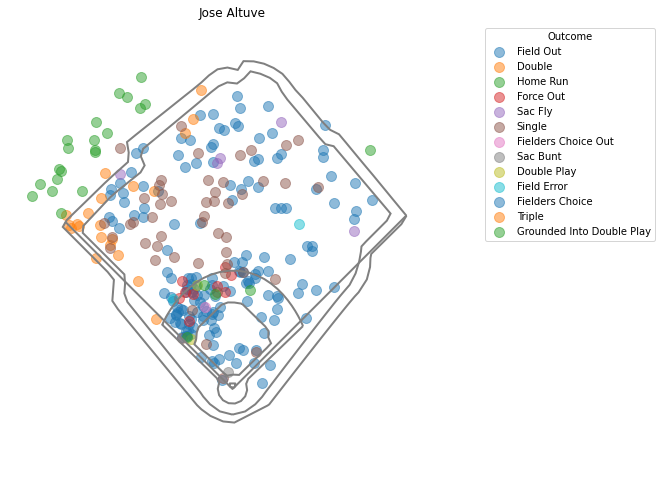

In [22]:
from pybaseball import statcast_batter, spraychart

sub_data = sc[sc['home_team'] == 'HOU']
spraychart(sub_data, 'astros', title='Jose Altuve')

In [14]:
from pybaseball import bwar_bat
bwar = bwar_bat()

In [64]:
bwar[(bwar['pitcher']=='N') & (bwar['year_ID']==2021)]

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
255,José Abreu,547989.0,abreujo02,2021,CHW,1,AL,N,152,659.0,17666666.0,7.4,8.4,-10.1,2.13,0.86,2.99
359,Ronald Acuna Jr.,660670.0,acunaro01,2021,ATL,1,NL,N,82,360.0,5000000.0,24.8,22.8,-0.8,1.17,2.41,3.58
384,Willy Adames,642715.0,adamewi01,2021,MIL,2,NL,N,99,413.0,NaN,21.7,23.7,2.9,1.41,2.09,3.50
385,Willy Adames,642715.0,adamewi01,2021,TBR,1,AL,N,41,142.0,NaN,1.7,-1.3,5.0,0.48,0.19,0.67
515,Matt Adams,571431.0,adamsma01,2021,COL,1,NL,N,22,40.0,NaN,-3.6,-4.6,0.7,0.13,-0.38,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117935,Andrew Young,670370.0,youngan02,2021,ARI,1,NL,N,58,104.0,NaN,-10.4,0.6,-10.6,0.35,-1.09,-0.74
118483,Seby Zavala,664874.0,zavalse01,2021,CHW,1,AL,N,37,104.0,NaN,-5.9,-2.9,-1.1,0.34,-0.58,-0.24
118592,Bradley Zimmer,605548.0,zimmebr01,2021,CLE,1,AL,N,99,348.0,NaN,-0.5,-3.5,2.3,1.16,0.01,1.17
118689,Ryan Zimmerman,475582.0,zimmery01,2021,WSN,1,NL,N,110,273.0,1000000.0,3.3,-1.7,2.2,0.93,0.27,1.20


In [30]:
playerid_lookup('cole', 'gerrit')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,cole,gerrit,543037,coleg001,colege01,13125,2013.0,2021.0


In [5]:
from pybaseball import top_prospects

# Get top pitching prospects for the Toronto Blue Jays
topProspects = top_prospects("astros")

ValueError: No tables found

### Batted Ball Profile  
GB% + FB% + LD% + PU%  
Pull % + Straight% + Oppo%  
Weak% + Topped% + Under% + Flare% + Solid% + Barrel%

Barrels are best, 95+ EV, ideal LA  
Solid makes up a space right next to barrels, slightly less ideal  
Flares are next best. These are more likely to be singles  
Topped are usually infield ground balls, generally 5 degrees or lower  
Under are typically weaker fly balls, often over 40 degrees  
Weak is particularly low EV

In [65]:
def load_data():
    df = pd.read_csv('hitting.csv')
    df.rename(columns={'b_total_pa':'pa', 'player_age':'age', 'player_id':'id', 'last_name':'last', ' first_name':'first', 
                       'b_k_percent':'k%', 'b_bb_percent':'bb%', 'exit_velocity_avg':'ev', 'launch_angle_avg':'la', 
                       'barrel_batted_rate':'barrel%', 'solidcontact_percent':'solid%', 'flareburner_percent':'flare%', 
                       'poorlyunder_percent':'under%', 'poorlytopped_percent':'topped%', 'poorlyweak_percent':'weak%', 
                       'hard_hit_percent':'hard%', 'groundballs_percent':'gb%', 'flyballs_percent':'fb%', 
                       'linedrives_percent':'ld%', 'pull_percent':'pull%', 'straightaway_percent':'straight%', 
                       'opposite_percent':'oppo%', 'batted_ball':'bbe', 'popups_percent':'pu%'
                      }, inplace=True)
    df['first'] = df['first'].str.strip()
    df['last'] = df['last'].str.strip()
    df = df[['id', 'first', 'last', 'year', 'age', 'pa', 'ev', 'la', 'k%', 'bb%', 'xba', 'xslg',
       'woba', 'xwoba', 'wobacon', 'xwobacon', 'xobp', 'xiso', 'gb%', 'fb%', 'ld%',
       'weak%', 'topped%', 'under%', 'flare%', 'solid%', 'hard%', 'barrel%']]
    return df

In [66]:
def scale_data(df, cols):
    """
    INPUT: 
        df: original dataframe
        list: subset of columns to scale
    OUTPUT:
        df: scaled data
    """
    scaler = MinMaxScaler()
    scaler.fit(df[cols])
    scaled_df = scaler.transform(df[cols])
    scaled_df = pd.DataFrame(scaled_df)
    scaled_df.columns=[df[cols].columns.tolist()]
    return scaled_df

In [68]:
# loads and cleans initial data
df = load_data()
# creates df from select columns and scales them
scaled_df = scale_data(df, cols)

In [69]:
# initialize a list of columns and a player to compare to
cols = ['weak%', 'topped%', 'under%', 'flare%', 'solid%', 'hard%']
player_id = df[(df['first']=='Jose') & (df['last']=='Altuve') & (df['year']==2017)].index[0]

In [70]:
df.loc[:,['id', 'first', 'last', 'year', 'age', 'woba', 'wobacon', 'xwobacon']+cols]

,id,first,last,year,age,woba,wobacon,xwobacon,weak%,topped%,under%,flare%,solid%,hard%
0,116338,Torii,Hunter,2015,40,0.304,0.343,0.325,2.9,39.0,24.5,21.6,5.2,35.3
1,120074,David,Ortiz,2015,40,0.379,0.418,0.470,1.6,27.1,24.0,24.9,8.4,49.5
2,120074,David,Ortiz,2016,41,0.420,0.458,0.457,0.9,24.5,27.3,20.7,8.1,48.2
3,121347,Alex,Rodriguez,2015,40,0.361,0.425,0.432,1.0,35.1,23.9,20.3,8.1,44.2
4,133380,Aramis,Ramirez,2015,37,0.309,0.329,0.318,3.4,29.4,30.3,23.3,6.6,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,669720,Austin,Hays,2021,26,0.328,0.384,0.366,4.7,33.0,27.0,21.0,5.2,39.2
978,670032,Nicky,Lopez,2021,26,0.329,0.340,0.278,7.1,44.7,19.4,24.0,3.9,26.9
979,670032,Nicky,Lopez,2020,25,0.254,0.265,0.315,8.4,42.7,17.6,26.7,3.1,26.7
980,670541,Yordan,Alvarez,2021,24,0.370,0.460,0.484,3.0,29.1,23.8,20.5,7.6,54.2


In [71]:
def add_distance_metrics(player_id, col_list):
    scaled_df = scale_data(df, col_list)
    df2 = df.loc[:,['id', 'first', 'last', 'year', 'age', 'woba', 'wobacon', 'xwobacon']+col_list]
    for j, i in scaled_df.iterrows():
        df2.at[j,'corr'] = pearsonr(scaled_df.loc[player_id,col_list],i[col_list])[0]
        df2.at[j,'eucl_dist'] = np.linalg.norm(scaled_df.loc[player_id,col_list] - i[col_list])
        df2.at[j,'manh_dist']= sum(abs(e - s) for s, e in zip(scaled_df.loc[player_id,col_list], i[col_list]))
    return df2

In [72]:
df['wobacon'].describe()

count    982.000000
mean       0.391219
std        0.052755
min        0.247000
25%        0.355000
50%        0.385000
75%        0.424000
max        0.600000
Name: wobacon, dtype: float64

In [73]:
df.iloc[:,6:].corr()

,ev,la,k%,bb%,xba,xslg,woba,xwoba,wobacon,xwobacon,xobp,xiso,gb%,fb%,ld%,weak%,topped%,under%,flare%,solid%,hard%,barrel%
ev,1.000000,0.101295,0.355494,0.368646,0.315558,0.720376,0.509918,0.678051,0.609804,0.749904,0.461207,0.731048,-0.168674,0.281480,0.005840,-0.512208,-0.226231,-0.174232,-0.211790,0.568544,0.935139,0.737514
la,0.101295,1.000000,0.198558,0.248284,-0.144948,0.322458,0.197909,0.243534,0.241114,0.276565,0.104247,0.440298,-0.951299,0.810220,0.100883,-0.093922,-0.922210,0.864131,-0.233074,0.382520,0.105334,0.378959
k%,0.355494,0.198558,1.000000,0.213817,-0.471562,0.194266,-0.010613,0.082754,0.524520,0.567886,-0.118607,0.416719,-0.186666,0.286684,-0.082103,0.042760,-0.258070,-0.025491,-0.371683,0.311404,0.423613,0.596948
bb%,0.368646,0.248284,0.213817,1.000000,0.061827,0.416617,0.518714,0.612431,0.369410,0.454254,0.769937,0.470246,-0.287232,0.322469,0.071285,-0.091423,-0.338664,0.077290,-0.130093,0.332048,0.390333,0.455150
xba,0.315558,-0.144948,-0.471562,0.061827,1.000000,0.603091,0.601055,0.671976,0.282711,0.364019,0.657882,0.321468,0.013700,-0.113469,0.423567,-0.193584,-0.027801,-0.326767,0.482957,0.156742,0.310615,0.146136
xslg,0.720376,0.322458,0.194266,0.416617,0.603091,1.000000,0.766804,0.937949,0.746427,0.895277,0.686470,0.949177,-0.417894,0.449378,0.197222,-0.249711,-0.487514,-0.042675,-0.138810,0.578597,0.754214,0.835529
woba,0.509918,0.197909,-0.010613,0.518714,0.601055,0.766804,1.000000,0.832510,0.806779,0.649264,0.770080,0.672986,-0.293860,0.254531,0.257071,-0.180946,-0.346433,-0.073205,0.016330,0.393361,0.521742,0.559982
xwoba,0.678051,0.243534,0.082754,0.612431,0.671976,0.937949,0.832510,1.000000,0.680856,0.832792,0.886656,0.848374,-0.351956,0.357829,0.265886,-0.230744,-0.427441,-0.105056,-0.003506,0.533878,0.713557,0.734840
wobacon,0.609804,0.241114,0.524520,0.369410,0.282711,0.746427,0.806779,0.680856,1.000000,0.854365,0.457704,0.774492,-0.316586,0.329727,0.178884,-0.128162,-0.395850,-0.112339,-0.175907,0.461420,0.646401,0.785284
xwobacon,0.749904,0.276565,0.567886,0.454254,0.364019,0.895277,0.649264,0.832792,0.854365,1.000000,0.573748,0.919258,-0.362929,0.415058,0.189095,-0.175425,-0.460698,-0.139424,-0.181877,0.577213,0.804226,0.923218


In [74]:
df[df['last']=='Altuve'].sort_values('year')

,id,first,last,year,age,pa,ev,la,k%,bb%,xba,xslg,woba,xwoba,wobacon,xwobacon,xobp,xiso,gb%,fb%,ld%,weak%,topped%,under%,flare%,solid%,hard%,barrel%
322,514888,Jose,Altuve,2015,25,689,86.1,11.2,9.7,4.8,0.259,0.377,0.347,0.297,0.367,0.308,0.304,0.118,47.6,21.7,23.4,4.5,35.9,26.6,23.4,4.8,28.9,3.1
327,514888,Jose,Altuve,2016,26,717,88.3,11.4,9.8,8.4,0.313,0.516,0.391,0.378,0.409,0.394,0.376,0.203,43.4,22.2,30.0,3.6,31.2,19.8,29.5,6.6,37.0,6.9
323,514888,Jose,Altuve,2017,27,662,86.1,9.7,12.7,8.8,0.286,0.470,0.405,0.355,0.435,0.371,0.358,0.184,48.3,21.3,25.2,6.1,34.6,19.8,26.0,4.9,28.1,6.7
325,514888,Jose,Altuve,2018,28,599,87.2,10.1,13.2,9.2,0.287,0.452,0.363,0.352,0.385,0.371,0.360,0.165,48.1,22.4,25.5,5.0,36.2,22.0,24.8,5.0,33.3,6.1
324,514888,Jose,Altuve,2019,29,548,87.4,9.7,15.0,7.5,0.260,0.469,0.374,0.335,0.414,0.363,0.319,0.210,50.7,21.8,19.7,6.4,36.0,21.1,20.6,4.0,34.5,8.1
328,514888,Jose,Altuve,2020,30,210,86.7,9.3,18.6,8.1,0.229,0.347,0.278,0.286,0.299,0.310,0.295,0.118,51.0,20.3,20.9,8.5,35.9,24.2,20.3,5.9,33.3,4.6
326,514888,Jose,Altuve,2021,31,678,87.6,15.7,13.4,9.7,0.258,0.414,0.357,0.330,0.376,0.341,0.335,0.156,41.0,24.6,23.6,6.2,28.0,29.4,23.6,6.2,34.9,6.4


In [75]:
df.columns

Index(['id', 'first', 'last', 'year', 'age', 'pa', 'ev', 'la', 'k%', 'bb%',
       'xba', 'xslg', 'woba', 'xwoba', 'wobacon', 'xwobacon', 'xobp', 'xiso',
       'gb%', 'fb%', 'ld%', 'weak%', 'topped%', 'under%', 'flare%', 'solid%',
       'hard%', 'barrel%'],
      dtype='object')

In [76]:
cols = ['bb%', 'k%', 'weak%', 'topped%', 'under%', 'flare%', 'solid%', 'hard%']
player_id = df[(df['first']=='George') & (df['last']=='Springer III') & (df['year']==2017)].index[0]

In [77]:
df[df['first']=='George']

,id,first,last,year,age,pa,ev,la,k%,bb%,xba,xslg,woba,xwoba,wobacon,xwobacon,xobp,xiso,gb%,fb%,ld%,weak%,topped%,under%,flare%,solid%,hard%,barrel%
482,543807,George,Springer III,2017,28,629,89.2,9.3,17.6,10.2,0.285,0.523,0.376,0.381,0.417,0.424,0.370,0.238,48.1,20.9,24.7,5.4,34.5,19.3,22.7,7.9,43.2,9.3
483,543807,George,Springer III,2019,30,556,89.8,10.5,20.3,12.1,0.276,0.564,0.400,0.391,0.466,0.451,0.371,0.288,44.6,24.3,25.1,5.4,31.4,18.6,21.1,5.9,44.8,14.1
484,543807,George,Springer III,2018,29,620,88.7,9.5,19.7,10.3,0.253,0.456,0.340,0.345,0.380,0.388,0.336,0.204,50.1,25.4,18.6,1.6,41.2,21.6,19.8,6.6,37.5,8.9
485,543807,George,Springer III,2016,27,744,89.4,8.8,23.9,11.8,0.256,0.461,0.353,0.353,0.417,0.417,0.355,0.205,49.5,21.6,24.4,3.9,35.1,20.1,22.5,6.0,39.1,10.5
486,543807,George,Springer III,2020,31,222,88.7,18.3,17.1,10.8,0.291,0.563,0.379,0.402,0.412,0.444,0.382,0.272,35.9,21.6,30.1,3.9,24.2,29.4,22.9,5.9,42.5,12.4


In [78]:
df2 = add_distance_metrics(player_id, cols)

In [79]:
df2.sort_values('corr',ascending=False).head(10)

,id,first,last,year,age,woba,wobacon,xwobacon,bb%,k%,weak%,topped%,under%,flare%,solid%,hard%,corr,eucl_dist,manh_dist
482,543807,George,Springer III,2017,28,0.376,0.417,0.424,10.2,17.6,5.4,34.5,19.3,22.7,7.9,43.2,1.000000,0.000000,0.000000
422,542303,Marcell,Ozuna,2017,27,0.388,0.468,0.436,9.4,21.2,5.7,32.3,20.6,23.6,8.1,45.6,0.887837,0.140728,0.355462
483,543807,George,Springer III,2019,30,0.400,0.466,0.451,12.1,20.3,5.4,31.4,18.6,21.1,5.9,44.8,0.815835,0.203682,0.491863
231,467092,Wilson,Ramos,2016,29,0.361,0.403,0.378,6.7,15.1,3.7,41.5,13.8,21.6,9.3,44.1,0.807267,0.347561,0.872211
748,605137,Josh,Bell,2021,29,0.352,0.385,0.399,11.4,17.8,2.3,41.5,15.8,24.8,6.8,52.0,0.791548,0.393610,0.941300
956,665489,Vladimir,Guerrero Jr.,2021,22,0.419,0.465,0.458,12.3,15.8,1.2,33.3,19.6,21.4,8.9,55.2,0.784516,0.440655,0.888602
438,543063,Brandon,Crawford,2015,28,0.332,0.394,0.400,7.0,21.2,3.6,36.5,15.1,23.0,8.2,45.0,0.767537,0.274612,0.641565
954,665487,Fernando,Tatis Jr.,2020,21,0.392,0.479,0.526,10.5,23.7,0.6,37.2,14.6,20.1,7.9,62.2,0.766596,0.595676,1.275809
73,434670,Hanley,Ramirez,2016,33,0.367,0.422,0.384,9.7,19.4,2.8,36.5,20.1,20.6,7.2,43.0,0.762807,0.259369,0.518892
957,665489,Vladimir,Guerrero Jr.,2020,21,0.338,0.366,0.358,8.2,15.6,1.1,43.7,20.2,19.7,6.0,50.8,0.752238,0.501042,1.174793


In [80]:
df2.sort_values('eucl_dist').head(10)

,id,first,last,year,age,woba,wobacon,xwobacon,bb%,k%,weak%,topped%,under%,flare%,solid%,hard%,corr,eucl_dist,manh_dist
482,543807,George,Springer III,2017,28,0.376,0.417,0.424,10.2,17.6,5.4,34.5,19.3,22.7,7.9,43.2,1.000000,0.000000,0.000000
422,542303,Marcell,Ozuna,2017,27,0.388,0.468,0.436,9.4,21.2,5.7,32.3,20.6,23.6,8.1,45.6,0.887837,0.140728,0.355462
483,543807,George,Springer III,2019,30,0.400,0.466,0.451,12.1,20.3,5.4,31.4,18.6,21.1,5.9,44.8,0.815835,0.203682,0.491863
878,641820,Trey,Mancini III,2021,29,0.326,0.389,0.409,8.3,23.2,5.6,33.1,17.6,25.1,8.0,42.0,0.658153,0.225735,0.497420
211,460086,Alex,Gordon,2019,35,0.319,0.333,0.343,8.1,15.8,5.2,35.6,23.1,23.1,5.6,38.4,0.684713,0.230384,0.551721
921,656976,Pavin,Smith,2021,25,0.318,0.361,0.361,7.7,19.4,7.4,34.1,20.6,24.4,8.4,42.7,0.698756,0.235719,0.513591
851,624577,Yasiel,Puig,2017,27,0.349,0.385,0.396,11.2,17.5,5.4,35.4,22.8,21.5,5.0,37.6,0.638781,0.239981,0.516881
241,471865,Carlos,Gonzalez,2017,32,0.327,0.379,0.342,10.5,22.3,5.6,39.5,20.7,22.4,5.9,37.0,0.571303,0.243709,0.566450
571,571976,Wil,Myers,2016,26,0.341,0.408,0.395,10.1,23.7,3.8,36.7,22.3,22.7,7.0,39.3,0.545765,0.248974,0.566243
575,572039,Stephen,Piscotty,2016,25,0.345,0.398,0.391,7.9,20.5,4.4,31.4,23.7,23.9,6.9,38.3,0.490901,0.253882,0.693514


In [81]:
df2.sort_values('manh_dist').head(10)

,id,first,last,year,age,woba,wobacon,xwobacon,bb%,k%,weak%,topped%,under%,flare%,solid%,hard%,corr,eucl_dist,manh_dist
482,543807,George,Springer III,2017,28,0.376,0.417,0.424,10.2,17.6,5.4,34.5,19.3,22.7,7.9,43.2,1.000000,0.000000,0.000000
422,542303,Marcell,Ozuna,2017,27,0.388,0.468,0.436,9.4,21.2,5.7,32.3,20.6,23.6,8.1,45.6,0.887837,0.140728,0.355462
483,543807,George,Springer III,2019,30,0.400,0.466,0.451,12.1,20.3,5.4,31.4,18.6,21.1,5.9,44.8,0.815835,0.203682,0.491863
878,641820,Trey,Mancini III,2021,29,0.326,0.389,0.409,8.3,23.2,5.6,33.1,17.6,25.1,8.0,42.0,0.658153,0.225735,0.497420
921,656976,Pavin,Smith,2021,25,0.318,0.361,0.361,7.7,19.4,7.4,34.1,20.6,24.4,8.4,42.7,0.698756,0.235719,0.513591
851,624577,Yasiel,Puig,2017,27,0.349,0.385,0.396,11.2,17.5,5.4,35.4,22.8,21.5,5.0,37.6,0.638781,0.239981,0.516881
73,434670,Hanley,Ramirez,2016,33,0.367,0.422,0.384,9.7,19.4,2.8,36.5,20.1,20.6,7.2,43.0,0.762807,0.259369,0.518892
442,543063,Brandon,Crawford,2021,34,0.377,0.435,0.398,10.2,19.1,3.4,29.8,24.5,22.5,8.4,43.3,0.613323,0.261696,0.520609
706,596019,Francisco,Lindor,2021,28,0.317,0.339,0.374,11.1,18.3,5.2,29.3,27.7,21.6,7.7,44.1,0.557158,0.296051,0.548751
211,460086,Alex,Gordon,2019,35,0.319,0.333,0.343,8.1,15.8,5.2,35.6,23.1,23.1,5.6,38.4,0.684713,0.230384,0.551721
